In [89]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
from datetime import datetime

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.util import constants

In [2]:
df_log = pd.read_csv('ecommerce_event_log.csv')
log = pm4py.format_dataframe(df_log, case_id='case:id', activity_key='concept:name', timestamp_key='time:timestamp')

In [42]:
print("=== ОБЗОР ДАННЫХ ===")
print(f"Всего событий: {len(log)}")
print(f"Всего уникальных заказов (кейсов): {len(log['case:id'].unique())}")
print(f"Уникальные активности: {log['concept:name'].unique()}")
print(f"Период данных: с {log['time:timestamp'].min()} по {log['time:timestamp'].max()}")

=== ОБЗОР ДАННЫХ ===
Всего событий: 6871
Всего уникальных заказов (кейсов): 1500
Уникальные активности: <StringArray>
[    'Order Created',  'Payment Approved',      'Item Shipped',
   'Order Delivered',    'Payment Failed',     'Payment Retry',
   'Order Cancelled', 'Item Out of Stock',   'Restocking Wait',
     'Item Returned']
Length: 10, dtype: string
Период данных: с 2024-01-01 00:00:00+00:00 по 2024-04-09 23:00:00+00:00


In [7]:
# Частота активностей
activity_counts = log['concept:name'].value_counts()
print("\nЧастота активностей:")
print(activity_counts)


Частота активностей:
concept:name
Order Created        1500
Payment Approved     1275
Item Shipped         1275
Order Delivered      1275
Payment Retry         512
Payment Failed        331
Order Cancelled       225
Item Out of Stock     225
Restocking Wait       225
Item Returned          28
Name: count, dtype: Int64


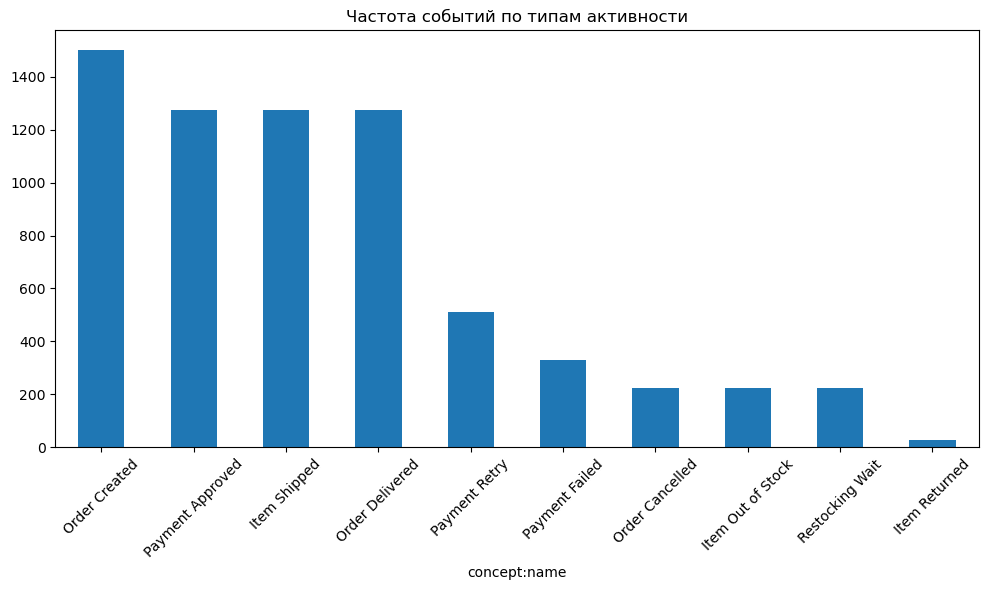

In [9]:
# Визуализация частоты активностей
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='bar')
plt.title('Частота событий по типам активности')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== ОБНАРУЖЕНИЕ ПРОЦЕССА ===


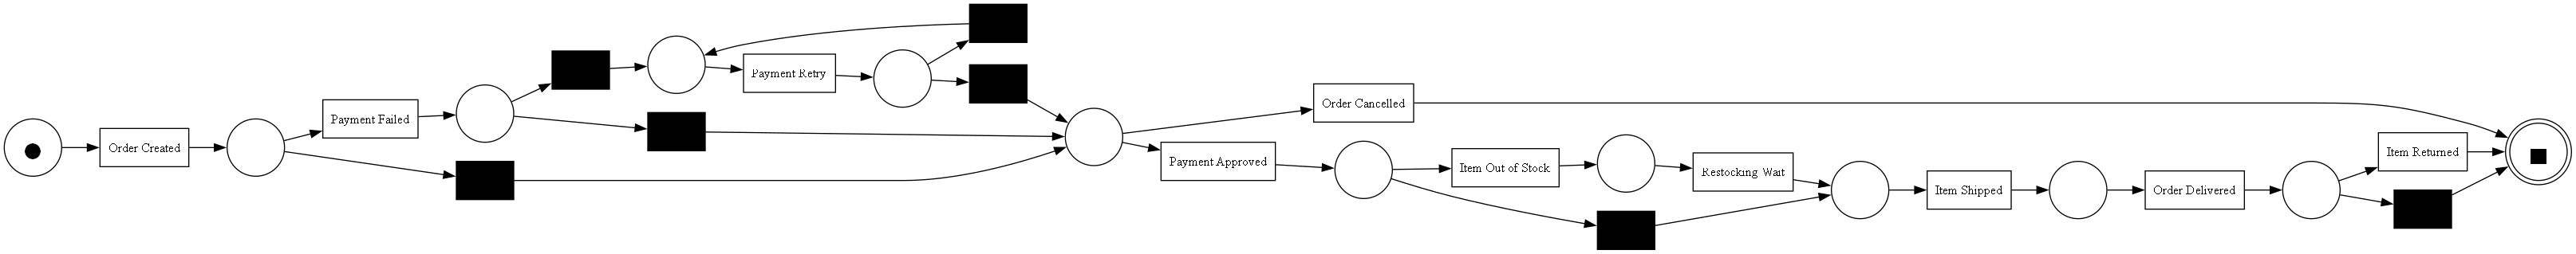

In [40]:
# Строим модель процесса в виде Petri net (сети Петри) используя алгоритм Inductive Miner
print("\n=== ОБНАРУЖЕНИЕ ПРОЦЕССА ===")

net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

# Визуализируем модель процесса
pm4py.view_petri_net(net, initial_marking, final_marking)

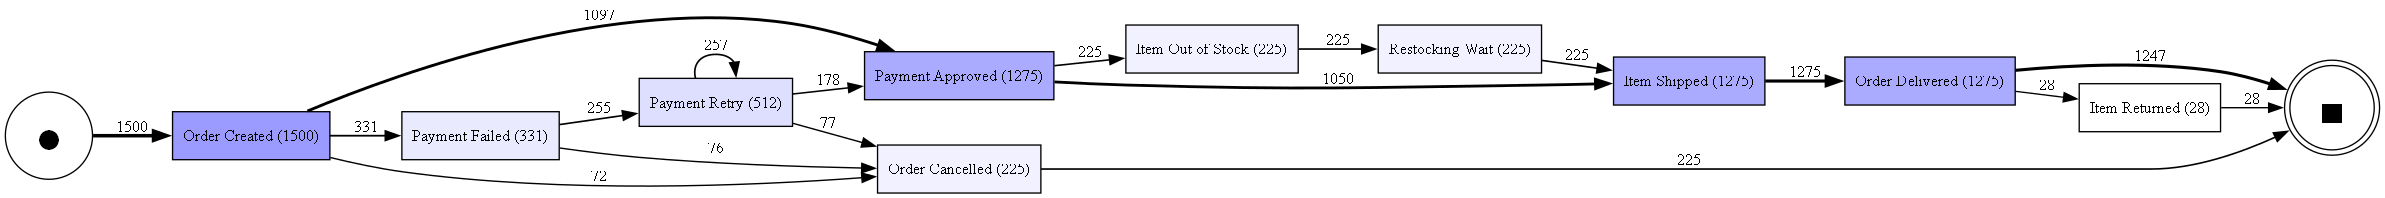

In [15]:
# Альтернатива: Строим Directly-Follows Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(log)

# Визуализируем DFG (более простая и наглядная модель)
pm4py.view_dfg(dfg, start_activities, end_activities)

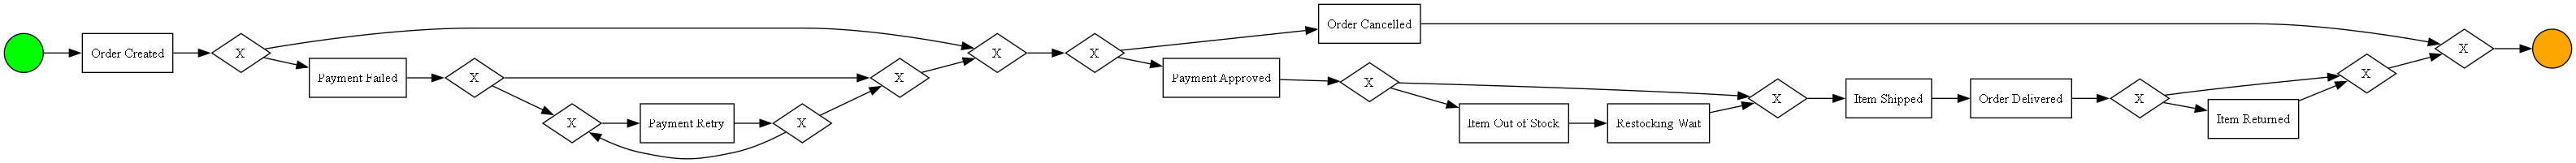

In [46]:
# Discovery BPMN модели из лога
bpmn_graph = pm4py.discover_bpmn_inductive(log)
pm4py.view_bpmn(bpmn_graph)

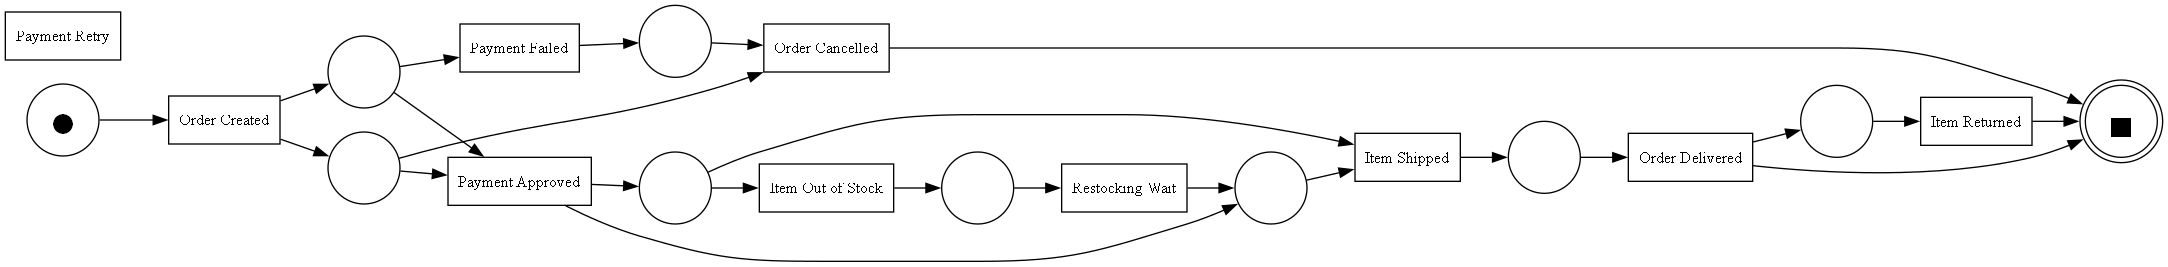

In [69]:
# Alpha Miner
net_alpha, initial_marking_alpha, final_marking_alpha = pm4py.discover_petri_net_alpha(log)
pm4py.view_petri_net(net_alpha, initial_marking_alpha, final_marking_alpha)

Успешных заказов: 1275


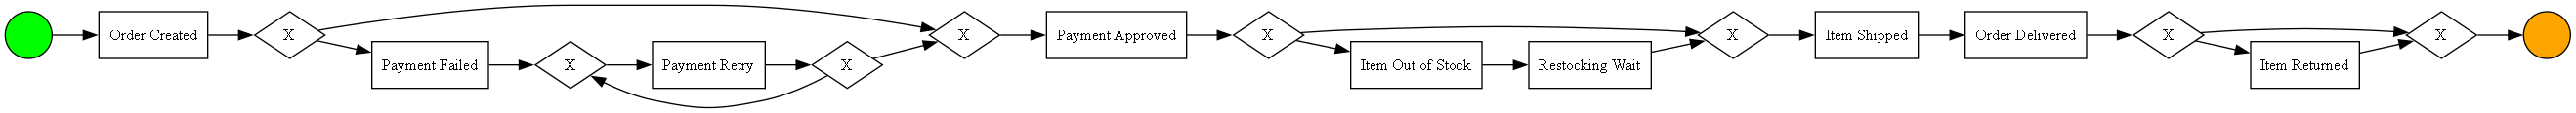

In [87]:
successful_cases = log[log['concept:name'] == 'Order Delivered']['case:id'].unique()
successful_log = log[log['case:id'].isin(successful_cases)]

print(f"Успешных заказов: {len(successful_cases)}")

if len(successful_log) > 0:
    bpmn_success = pm4py.discover_bpmn_inductive(successful_log)
    pm4py.view_bpmn(bpmn_success)


=== АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ===
Средняя продолжительность выполнения заказа: 6.47 дней


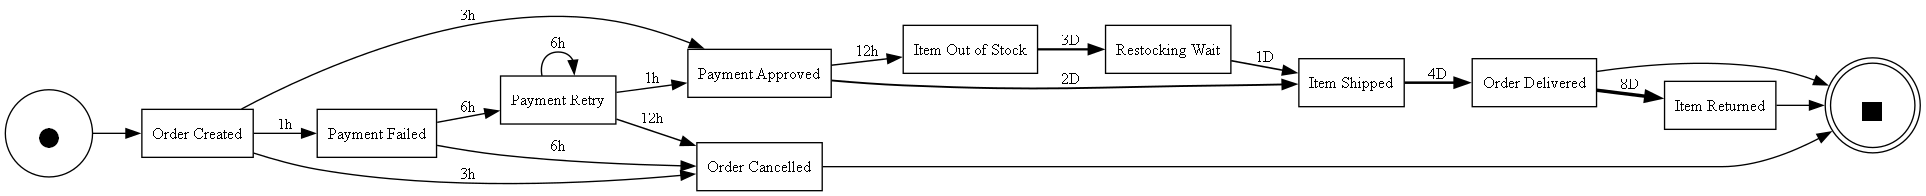

In [34]:
print("\n=== АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ===")

# Считаем среднюю продолжительность каждого кейса (заказа)
case_durations = pm4py.get_all_case_durations(log)
average_duration = sum(case_durations) / len(case_durations)
print(f"Средняя продолжительность выполнения заказа: {average_duration / (24*3600):.2f} дней")

# Анализ времени между конкретными событиями
# Например, сколько времени в среднем проходит между "Оплата подтверждена" и "Товар отправлен"
performance_dfg = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(*performance_dfg)

In [36]:
# Мы можем проанализировать, на каких этапах происходит наибольшая задержка
# Создаем timeline для визуализации задержек
# Анализ активностей, которые занимают больше всего времени
activities_avg_time = {}
for activity in log['concept:name'].unique():
    activity_events = log[log['concept:name'] == activity]
    if len(activity_events) > 1:
        # Берем разницу между максимальным и минимальным временем события для этой активности в каждом кейсе
        # Это упрощенный подход, в реальности анализ сложнее
        activity_events_per_case = activity_events.groupby('case:id')['time:timestamp'].agg(['min', 'max'])
        activity_events_per_case['duration'] = (activity_events_per_case['max'] - activity_events_per_case['min']).dt.total_seconds()
        avg_duration = activity_events_per_case['duration'].mean()
        activities_avg_time[activity] = avg_duration

print("\nСредняя продолжительность выполнения активностей (в часах):")
for activity, duration in sorted(activities_avg_time.items(), key=lambda x: x[1], reverse=True):
    print(f"  {activity}: {duration/3600:.2f} часов")


Средняя продолжительность выполнения активностей (в часах):
  Payment Retry: 6.31 часов
  Order Created: 0.00 часов
  Payment Approved: 0.00 часов
  Item Shipped: 0.00 часов
  Order Delivered: 0.00 часов
  Payment Failed: 0.00 часов
  Order Cancelled: 0.00 часов
  Item Out of Stock: 0.00 часов
  Restocking Wait: 0.00 часов
  Item Returned: 0.00 часов



=== АНАЛИЗ ПУТЕЙ К ОТМЕНЕ ЗАКАЗА ===
Проанализировано 225 отмененных заказов


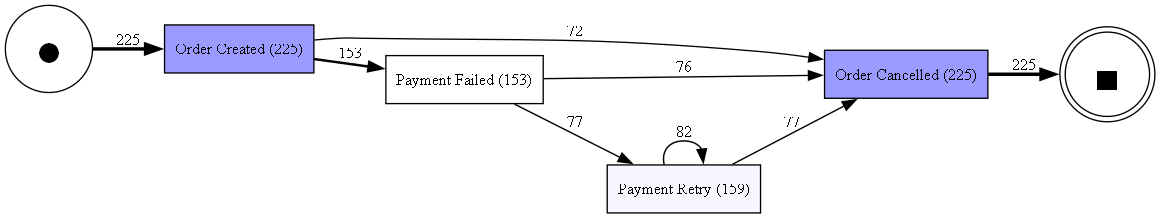

In [38]:
print("\n=== АНАЛИЗ ПУТЕЙ К ОТМЕНЕ ЗАКАЗА ===")

# Фильтруем кейсы, которые закончились отменой
cancelled_cases = log[log['concept:name'] == 'Order Cancelled']['case:id'].unique()
cancelled_log = log[log['case:id'].isin(cancelled_cases)]

if len(cancelled_log) > 0:
    # Смотрим, какие активности чаще всего предшествуют отмене
    print(f"Проанализировано {len(cancelled_cases)} отмененных заказов")
    
    # Строим процесс только для отмененных заказов
    cancelled_net, cancelled_im, cancelled_fm = pm4py.discover_dfg(cancelled_log)
    pm4py.view_dfg(cancelled_net, cancelled_im, cancelled_fm, ) # Сохраняем в файл для отмененных заказов
else:
    print("Нет отмененных заказов для анализа")

Отмененных заказов: 225


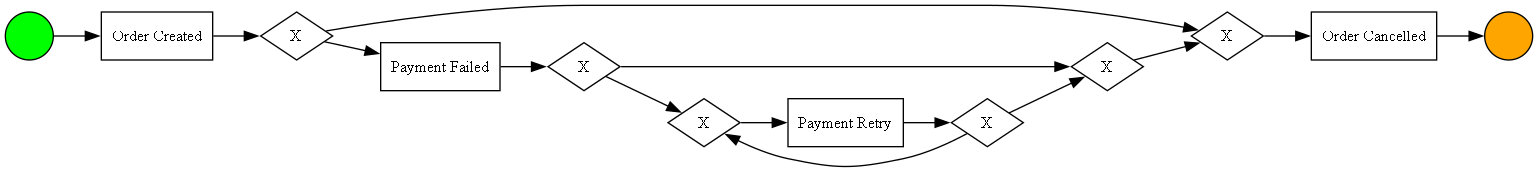

In [83]:
cancelled_cases = log[log['concept:name'] == 'Order Cancelled']['case:id'].unique()
cancelled_log = log[log['case:id'].isin(cancelled_cases)]

print(f"Отмененных заказов: {len(cancelled_cases)}")

if len(cancelled_log) > 0:
    bpmn_cancelled = pm4py.discover_bpmn_inductive(cancelled_log)
    pm4py.view_bpmn(bpmn_cancelled)